In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to clear outputs from cells
from IPython.display import clear_output

In [2]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')
    
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)
    
# save radius array as a pickle
with open('radius_array.pkl', 'rb') as f:
    r = pickle.load(f)

In [3]:
print('shape x:', x.shape)

shape x: (18, 201, 36, 8)


In [4]:
var_list

['temperature',
 'vx',
 'vy',
 'vz',
 'thermal conductivity',
 'thermal expansivity',
 'temperature anomaly',
 'spin transition-induced density anomaly']

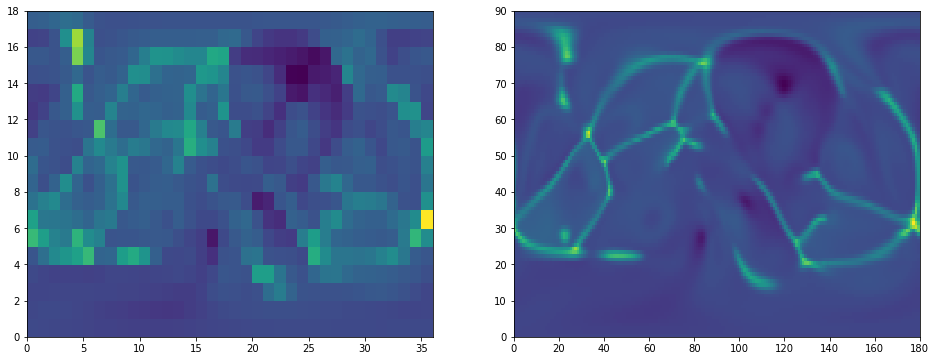

In [5]:
r_index = 16
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[:,r_index,:,var_index])
ax[1].pcolormesh(x_large[:,r_index,:,var_index])
plt.show()

Change the orientation of the axis so that it alingns with the expected input: $(N, C_{in},D_{in},H_{in},W_{in})$

In [6]:
x.shape

(18, 201, 36, 8)

In [7]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)

torch.Size([1, 8, 201, 18, 36])
torch.Size([1, 8, 201, 90, 180])


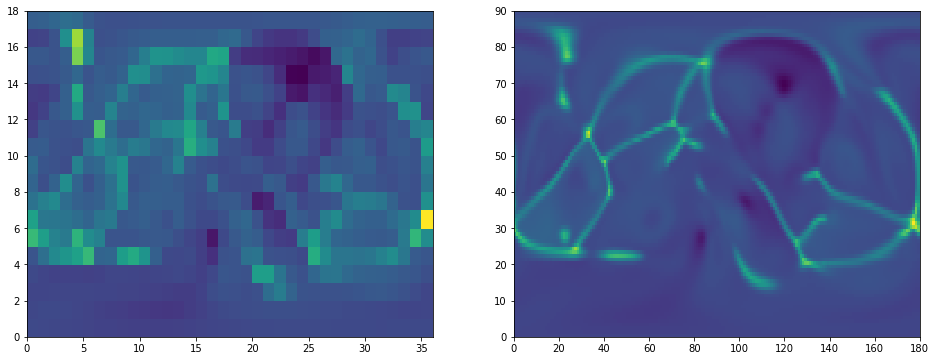

In [8]:
r_index = 16
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
plt.show()

# Try 3D Convolutions
https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html

![shape](./img/shape.png)

In [213]:
x.shape

torch.Size([1, 8, 201, 18, 36])

Try a convolution on sample data with same shape as `x`:

In [283]:
conv_layer = nn.Conv3d(in_channels=8, 
                       out_channels=32, 
                       kernel_size=2, 
                       stride=2, 
                       dilation=1)


a = torch.rand([1, 8, 200, 20, 40])
print('shape a:',a.shape)
output = conv_layer(a)
output.shape

shape a: torch.Size([1, 8, 200, 20, 40])


torch.Size([1, 32, 100, 10, 20])

In [284]:
max_layer = nn.MaxPool3d((2, 2, 2))
output = max_layer(output)
output.shape

torch.Size([1, 32, 50, 5, 10])

Let's try it on the `x` data. First, we will "pad" the edges to make a height and width of 20x40.

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])


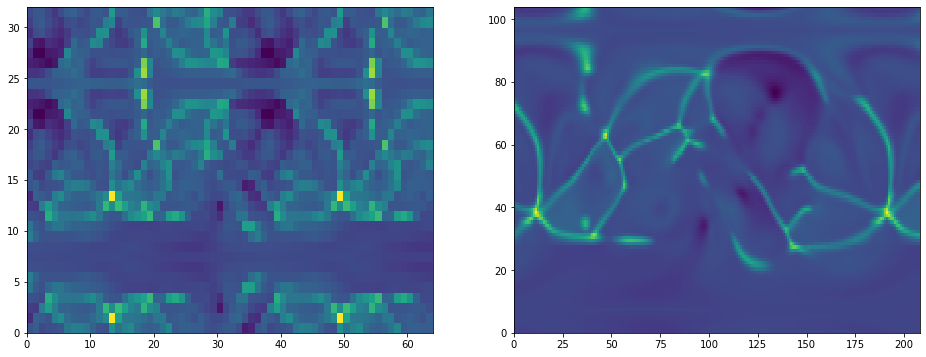

x.shape: torch.Size([1, 8, 200, 32, 64])
x_large.shape: torch.Size([1, 8, 201, 104, 208])


In [727]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 14
x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 7
x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                     x, 
                     torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
              axis=-2) # append along longitudinal (left-right) axis

x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                     x_large, 
                     torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                    axis=-2)

r_index = 16
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
plt.show()
print('x.shape:', x.shape)
print('x_large.shape:', x_large.shape)

**Attempt 1:**

In [795]:
conv1 = nn.Conv3d(in_channels=8, out_channels=256, kernel_size=4, stride=4, dilation=1)
max_layer1 = nn.MaxPool3d((2, 2, 2))
conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=1, stride=1, dilation=1)
batch1 = nn.BatchNorm3d(128)
conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1)
conv4 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1)

# upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
conv5 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1)
conv6 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1)
conv7 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=1, stride=1, dilation=1)
upsample_layer = nn.Upsample(scale_factor=(4, 4, 4))
conv8 = nn.Conv3d(in_channels=256, out_channels=256, kernel_size=2, stride=2, dilation=1)
upsample_layer2 = nn.Upsample(scale_factor=(8, 8, 8))
conv9 = nn.Conv3d(in_channels=256, out_channels=8, kernel_size=2, stride=2, dilation=1)



print('shape x:',x.shape,'\n')
output1 = conv1(x)
print('conv1 output:', output1.shape)
output2 = max_layer1(output1)
print('max-pool output:', output2.shape)
output3 = conv2(output2)
print('conv2 output:', output3.shape)
output4 = batch1(output3)
print('batch-norm output:', output4.shape)
output5 = conv3(output4)
print('conv3 output:', output5.shape,)
output6 = conv4(output5)
print('conv4 output:', output6.shape, '\n')

output7 = conv5(output6)
print('conv5 output:', output7.shape)
output8 = conv6(output7)
print('conv6 output:', output8.shape)
output9 = conv7(output8)
print('conv7 output:', output9.shape)
output10 = upsample_layer(output9)
print('upsample1 output:', output10.shape)
output11 = conv8(output10)
print('conv8 output:', output11.shape)
output12 = upsample_layer2(output11)
print('upsampe2 output:', output12.shape)
output13 = conv9(output12)
print('conv9 output:', output13.shape)

shape x: torch.Size([1, 8, 200, 32, 64]) 

conv1 output: torch.Size([1, 256, 50, 8, 16])
max-pool output: torch.Size([1, 256, 25, 4, 8])
conv2 output: torch.Size([1, 128, 25, 4, 8])
batch-norm output: torch.Size([1, 128, 25, 4, 8])
conv3 output: torch.Size([1, 64, 25, 4, 8])
conv4 output: torch.Size([1, 32, 25, 4, 8]) 

conv5 output: torch.Size([1, 64, 25, 4, 8])
conv6 output: torch.Size([1, 128, 25, 4, 8])
conv7 output: torch.Size([1, 256, 25, 4, 8])
upsample1 output: torch.Size([1, 256, 100, 16, 32])
conv8 output: torch.Size([1, 256, 50, 8, 16])
upsampe2 output: torch.Size([1, 256, 400, 64, 128])
conv9 output: torch.Size([1, 8, 200, 32, 64])


## Try Smaller Data

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])


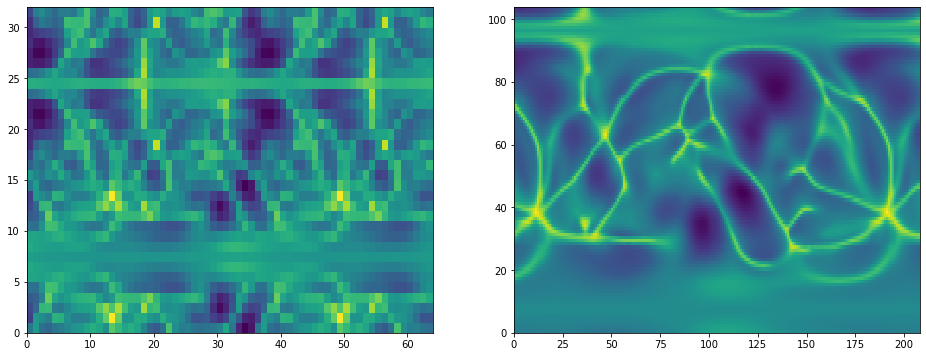

x.shape: torch.Size([1, 2, 8, 32, 64])
x_large.shape: torch.Size([1, 8, 201, 104, 208])


In [2]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 14
x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 7
x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                     x, 
                     torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
              axis=-2) # append along longitudinal (left-right) axis

x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                     x_large, 
                     torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                    axis=-2)

# only select 8 raidal layers, and 2 variables ("channels")

x = x[:,:2,:8,:,:]

r_index = 3
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
plt.show()
print('x.shape:', x.shape)
print('x_large.shape:', x_large.shape)

In [802]:
conv1 = nn.Conv3d(in_channels=2, out_channels=256, kernel_size=4, stride=4, dilation=1)
max_layer1 = nn.MaxPool3d((2, 2, 2))
conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=1, stride=1, dilation=1)
batch1 = nn.BatchNorm3d(128)
conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1)
conv4 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1)

# upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
conv5 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1)
conv6 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1)
conv7 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=1, stride=1, dilation=1)
upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
trans1 = nn.ConvTranspose3d(in_channels=256, out_channels=2, kernel_size=4, stride=4, dilation=1)



print('shape x:',x.shape,'\n')
output1 = conv1(x)
print('conv1 output:', output1.shape)
output2 = max_layer1(output1)
print('max-pool output:', output2.shape)
output3 = conv2(output2)
print('conv2 output:', output3.shape)
output4 = batch1(output3)
print('batch-norm output:', output4.shape)
output5 = conv3(output4)
print('conv3 output:', output5.shape,)
output6 = conv4(output5)
print('conv4 output:', output6.shape, '\n')

output7 = conv5(output6)
print('conv5 output:', output7.shape)
output8 = conv6(output7)
print('conv6 output:', output8.shape)
output9 = conv7(output8)
print('conv7 output:', output9.shape)
output10 = upsample_layer(output9)
print('upsample1 output:', output10.shape)
output11 = trans1(output10)
print('conv8 output:', output11.shape)
# output12 = upsample_layer2(output11)
# print('upsampe2 output:', output12.shape)
# output13 = conv9(output12)
# print('conv9 output:', output13.shape)

shape x: torch.Size([1, 2, 8, 32, 64]) 

conv1 output: torch.Size([1, 256, 2, 8, 16])
max-pool output: torch.Size([1, 256, 1, 4, 8])
conv2 output: torch.Size([1, 128, 1, 4, 8])
batch-norm output: torch.Size([1, 128, 1, 4, 8])
conv3 output: torch.Size([1, 64, 1, 4, 8])
conv4 output: torch.Size([1, 32, 1, 4, 8]) 

conv5 output: torch.Size([1, 64, 1, 4, 8])
conv6 output: torch.Size([1, 128, 1, 4, 8])
conv7 output: torch.Size([1, 256, 1, 4, 8])
upsample1 output: torch.Size([1, 256, 2, 8, 16])
conv8 output: torch.Size([1, 2, 8, 32, 64])


Try an even smaller network:

In [3]:
conv1 = nn.Conv3d(in_channels=2, out_channels=64, kernel_size=2, stride=2, dilation=1)
max_layer1 = nn.MaxPool3d((2, 2, 2))
conv2 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1)

# upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1)
upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
trans1 = nn.ConvTranspose3d(in_channels=64, out_channels=2, kernel_size=2, stride=2, dilation=1)



print('shape x:',x.shape,'\n')
output1 = conv1(x)
print('conv1 output:', output1.shape)
output2 = max_layer1(output1)
print('max-pool output:', output2.shape)
output3 = conv2(output2)
print('conv2 output:', output3.shape, '\n')

output4 = conv3(output3)
print('conv3 output:', output4.shape)
output5 = upsample_layer(output4)
print('upsample1 output:', output5.shape)
output6 = trans1(output5)
print('trans1 output:', output6.shape)
# output12 = upsample_layer2(output11)
# print('upsampe2 output:', output12.shape)
# output13 = conv9(output12)
# print('conv9 output:', output13.shape)

shape x: torch.Size([1, 2, 8, 32, 64]) 

conv1 output: torch.Size([1, 64, 4, 16, 32])
max-pool output: torch.Size([1, 64, 2, 8, 16])
conv2 output: torch.Size([1, 32, 2, 8, 16]) 

conv3 output: torch.Size([1, 64, 2, 8, 16])
upsample1 output: torch.Size([1, 64, 4, 16, 32])
trans1 output: torch.Size([1, 2, 8, 32, 64])


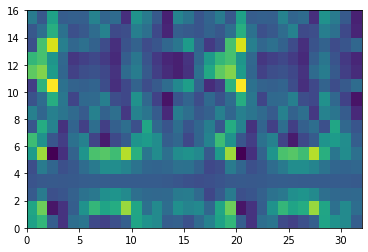

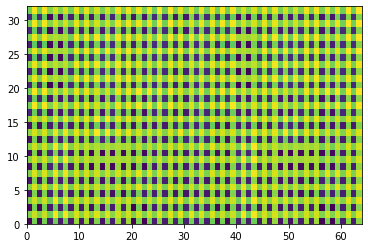

NameError: name 'output13' is not defined

In [4]:
# check out one of these conv layers
plt.pcolormesh(output1[0,1,1,:,:].detach())
plt.show()

# check out one of these conv layers
plt.pcolormesh(output6[0,0,0,:,:].detach())
plt.show()

plt.pcolormesh(output13[0,var_index,r_index,:,:].detach())
plt.show()

# Simple Autoencoder

From: https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html

In [ ]:
conv1 = nn.Conv3d(in_channels=2, out_channels=64, kernel_size=2, stride=2, dilation=1)
max_layer1 = nn.MaxPool3d((2, 2, 2))
conv2 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1)

# upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1)
upsample_layer = nn.Upsample(scale_factor=(2, 2, 2))
trans1 = nn.ConvTranspose3d(in_channels=64, out_channels=2, kernel_size=2, stride=2, dilation=1)

In [93]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv3d(in_channels=2, out_channels=128, kernel_size=2, stride=2, dilation=1),
#             nn.LeakyReLU(),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1),
            nn.ReLU(),
#             nn.BatchNorm3d(64),
#             nn.LeakyReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.ReLU(),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(128),
            nn.Upsample(scale_factor=(2, 2, 2)),
            nn.ConvTranspose3d(in_channels=128, out_channels=2, kernel_size=2, stride=2, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [94]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    batch_x = x.to(device)
    for epoch in range(num_epochs):
        recon = model(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 100 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])


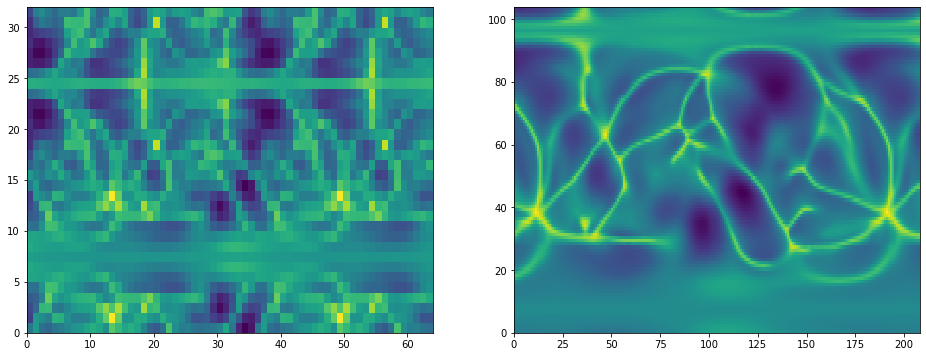

x.shape: torch.Size([1, 2, 8, 32, 64])
x_large.shape: torch.Size([1, 8, 201, 104, 208])


In [95]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 14
x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 7
x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                     x, 
                     torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
              axis=-2) # append along longitudinal (left-right) axis

x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                     x_large, 
                     torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                    axis=-2)

# only select 8 raidal layers, and 2 variables ("channels")

x = x[:,:2,:8,:,:]

r_index = 3
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
plt.show()
print('x.shape:', x.shape)
print('x_large.shape:', x_large.shape)

In [96]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")
# device = torch.device("cpu")
model = Autoencoder()
model.to(device)
train(x, model, device, num_epochs=2000, learning_rate=1e-3,)
clear_output(wait=False)

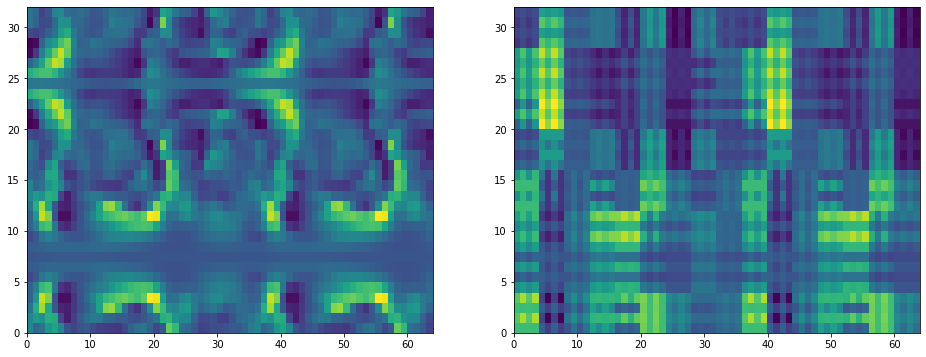

In [99]:
x_reconstruction = test(x, model, device)

r_index = 3
var_index = 1 # indexes with var_list
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:].detach())
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
plt.show()

In [100]:
# compute number of trainable parameters
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

21058


# More Complicated Autoencoder

In [115]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv3d(in_channels=2, out_channels=256, kernel_size=4, stride=4, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(in_channels=256, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.BatchNorm3d(64),
#             nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU()
        )
        
        self.decoder = nn.Sequential(
#             nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(64),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.Upsample(scale_factor=(2, 2, 2)),
            nn.ConvTranspose3d(in_channels=256, out_channels=2, kernel_size=4, stride=4, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [116]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 14
x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 7
x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                     x, 
                     torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
              axis=-2) # append along longitudinal (left-right) axis

x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                     x_large, 
                     torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                    axis=-2)

# only select 8 raidal layers, and 2 variables ("channels")

x = x[:,:2,:8,:,:]

r_index = 3
var_index = 0 # indexes with var_list

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# ax[0].pcolormesh(x[0,var_index,r_index,:,:])
# ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
# plt.show()
print('x.shape:', x.shape)
print('x_large.shape:', x_large.shape)

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])
x.shape: torch.Size([1, 2, 8, 32, 64])
x_large.shape: torch.Size([1, 8, 201, 104, 208])


In [117]:
x.shape

torch.Size([1, 2, 8, 32, 64])

In [118]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")
# device = torch.device("cpu")
model = Autoencoder()
model.to(device)
train(x, model, device, num_epochs=500, learning_rate=1e-3,)
clear_output(wait=False)

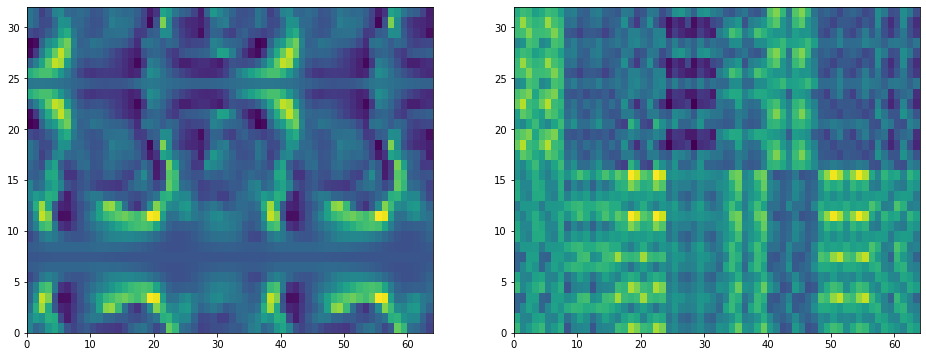

In [119]:
x_reconstruction = test(x, model, device)

r_index = 3
var_index = 1 # indexes with var_list
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:].detach())
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
plt.show()

In [120]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

149826


## Try without max pooling

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])


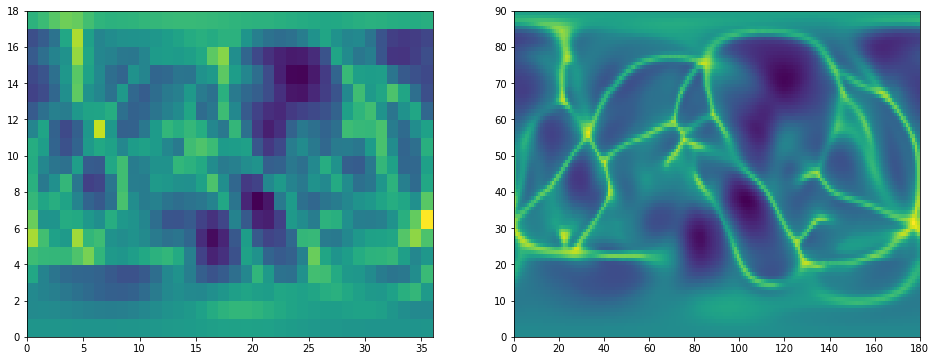

x.shape: torch.Size([1, 8, 27, 18, 36])
x_large.shape: torch.Size([1, 8, 201, 90, 180])


In [196]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 0

if pad_lat > 0:
    x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
    x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 0

if pad_lon > 0:
    x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
                  axis=-2) # append along longitudinal (left-right) axis

    x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                         x_large, 
                         torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                        axis=-2)

# only select 9 raidal layers, and 2 variables ("channels")

x = x[:,:,:27,:,:]

r_index = 3
var_index = 0 # indexes with var_list

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[1].pcolormesh(x_large[0,var_index,r_index,:,:])
plt.show()
print('x.shape:', x.shape)
print('x_large.shape:', x_large.shape)

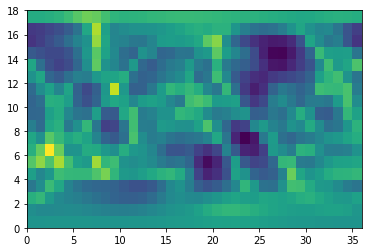

In [198]:
x_roll = torch.roll(x,3,4)
plt.pcolormesh(x_roll[0,var_index,r_index,:,:])

In [195]:
conv1 = nn.Conv3d(in_channels=8, out_channels=256, kernel_size=3, stride=3, dilation=1)
conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=3, dilation=1)
conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1)

conv4 = nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1)
conv5 = nn.ConvTranspose3d(in_channels=128, out_channels=256, kernel_size=3, stride=3, dilation=1)
conv6 = nn.ConvTranspose3d(in_channels=256, out_channels=8, kernel_size=3, stride=3, dilation=1)

layer_list = [conv1, conv2, conv3, conv4, conv5, conv6]

print('input x shape:', x.shape)

for i, l in enumerate(layer_list):
    if i == 0:
        output = l(x)
        print(f'conv{i+1} output:', output.shape)
    else:
        output = l(output)
        print(f'conv{i+1} output:', output.shape)

input x shape: torch.Size([1, 8, 27, 18, 36])
conv1 output: torch.Size([1, 256, 9, 6, 12])
conv2 output: torch.Size([1, 128, 3, 2, 4])
conv3 output: torch.Size([1, 64, 3, 2, 4])
conv4 output: torch.Size([1, 128, 3, 2, 4])
conv5 output: torch.Size([1, 256, 9, 6, 12])
conv6 output: torch.Size([1, 8, 27, 18, 36])


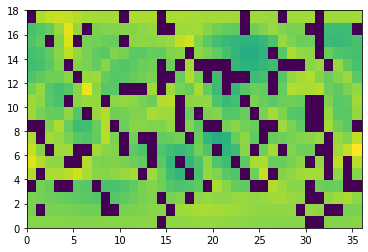

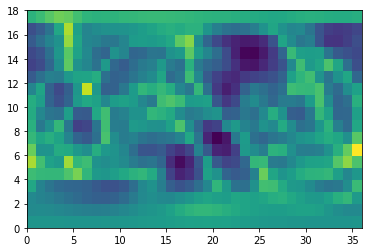

In [251]:
drop_layer = nn.Dropout(0.2)
output = drop_layer(x)

plt.pcolormesh(output[0,var_index,r_index,:,:])
plt.show()

plt.pcolormesh(x[0,var_index,r_index,:,:])
plt.show()

In [212]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    batch_x = x.to(device)
    for epoch in range(num_epochs):
        batch_x_roll = torch.roll(batch_x, np.random.randint(0,18), 4)
        recon = model(batch_x_roll)
        loss = criterion(recon, batch_x_roll)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 100 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [267]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            nn.Conv3d(in_channels=8, out_channels=64, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(64),
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(32),
            nn.Conv3d(in_channels=32, out_channels=16, kernel_size=1, stride=1, dilation=1),
#             nn.BatchNorm3d(64),
#             nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU()
        )
        
        self.decoder = nn.Sequential(
#             nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=16, out_channels=32, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
            nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=64, out_channels=8, kernel_size=3, stride=3, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [268]:
# use pytorch-summary https://github.com/sksq96/pytorch-summary
from torchsummary import summary

model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1        [-1, 8, 27, 18, 36]               0
            Conv3d-2         [-1, 64, 9, 6, 12]          13,888
         LeakyReLU-3         [-1, 64, 9, 6, 12]               0
       BatchNorm3d-4         [-1, 64, 9, 6, 12]             128
            Conv3d-5          [-1, 32, 3, 2, 4]          55,328
         LeakyReLU-6          [-1, 32, 3, 2, 4]               0
       BatchNorm3d-7          [-1, 32, 3, 2, 4]              64
            Conv3d-8          [-1, 16, 3, 2, 4]             528
   ConvTranspose3d-9          [-1, 32, 3, 2, 4]             544
        LeakyReLU-10          [-1, 32, 3, 2, 4]               0
      BatchNorm3d-11          [-1, 32, 3, 2, 4]              64
  ConvTranspose3d-12         [-1, 64, 9, 6, 12]          55,360
        LeakyReLU-13         [-1, 64, 9, 6, 12]               0
      BatchNorm3d-14         [-1, 64, 9

In [269]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

model = Autoencoder(drop_p=0.2)
model.to(device)
train(x, model, device, num_epochs=5000, learning_rate=1e-3,)
clear_output(wait=False)

This is how we can access the encoder and decoder:

In [295]:
encoder_output = model.encoder(x.to(device))
encoder_output.shape

torch.Size([1, 16, 3, 2, 4])

In [296]:
encoder_output.flatten().shape

torch.Size([384])

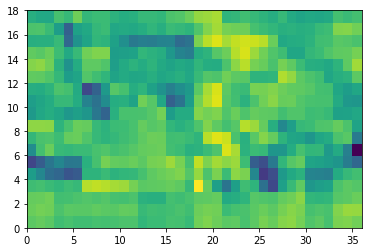

In [297]:
decoder_output = model.decoder(encoder_output)
plt.pcolormesh(decoder_output[0,var_index,r_index,:,:].cpu().detach())

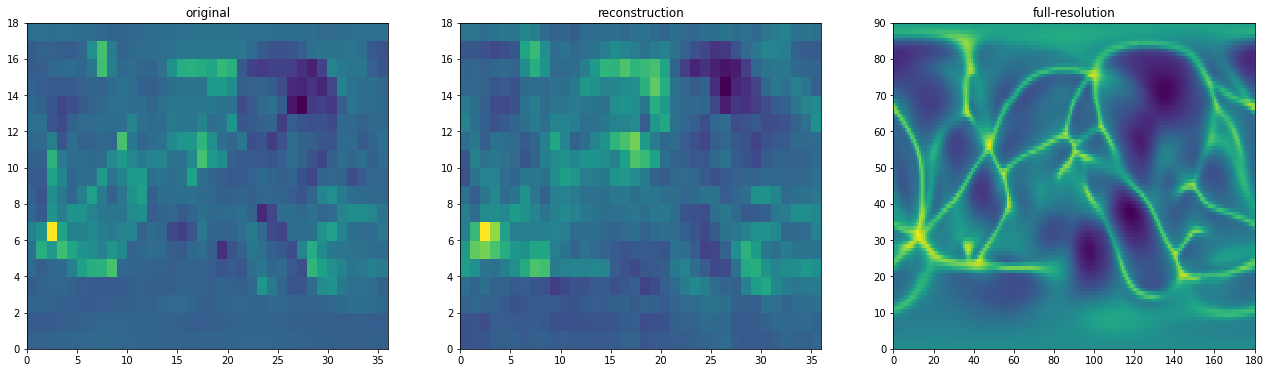

In [298]:
roll_amount = 3

x_roll = torch.roll(x,roll_amount,4)
x_large_roll = torch.roll(x_large, roll_amount*5, 4)
x_reconstruction = test(x_roll, model, device)

r_index = 3
var_index = 0 # indexes with var_list
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
ax[0].pcolormesh(x_roll[0,var_index,r_index,:,:].detach())
ax[0].set_title('original')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
ax[2].set_title('full-resolution')
plt.show()

torch.Size([1, 8, 200, 18, 36])
torch.Size([1, 8, 201, 90, 180])


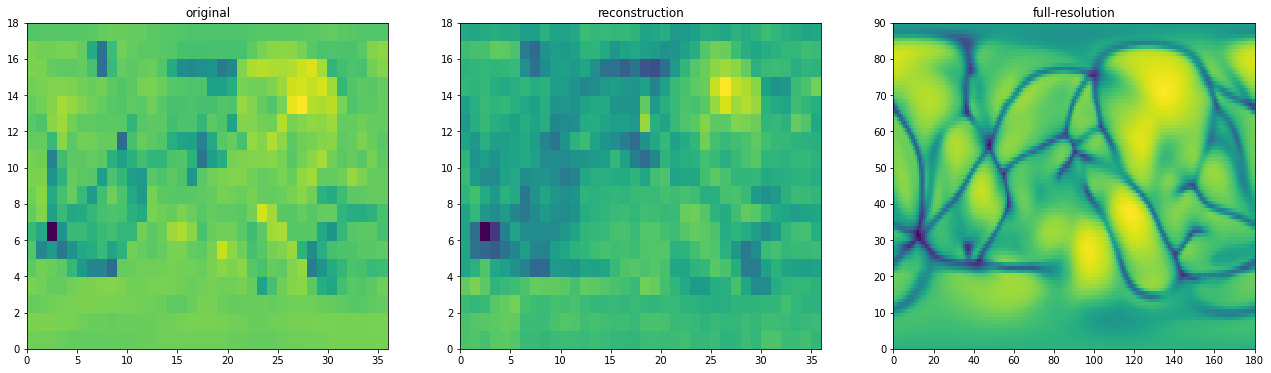

In [281]:
# generate results from an unseen data chunk
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:200,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)


###############################
# concatenate along sides
pad_lat = 0

if pad_lat > 0:
    x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
    x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 0

if pad_lon > 0:
    x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
                  axis=-2) # append along longitudinal (left-right) axis

    x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                         x_large, 
                         torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                        axis=-2)

# only select 9 raidal layers, and 2 variables ("channels")
radial_index_start = 27

x = x[:,:,radial_index_start:radial_index_start+27,:,:]

roll_amount = 3

x_roll = torch.roll(x,roll_amount,4)
x_large_roll = torch.roll(x_large, roll_amount*5, 4)
x_reconstruction = test(x_roll, model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = 3
var_index = 5 # indexes with var_list
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
ax[0].pcolormesh(x_roll[0,var_index,r_index,:,:].detach())
ax[0].set_title('original')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
ax[2].set_title('full-resolution')
plt.show()

Not bad! Looks like the model is generalizing somewhat.

In [274]:
print(var_list)

['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


In [299]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

139864


In [300]:
torch.save(model, 'model_test.pt')

# save pickle of x to compare
with open('x_test.pkl', 'wb') as f:
    pickle.dump(x, f)

In [301]:
x.shape

torch.Size([1, 8, 27, 18, 36])

In [302]:
x.flatten().shape

torch.Size([139968])

## Train Model on More data
We will train the autoencoder with the entire `x` and randomly "slide" the 27 layers between raidal index 0 and 200.

In [386]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)

torch.Size([1, 8, 201, 18, 36])
torch.Size([1, 8, 201, 90, 180])


In [387]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            nn.Conv3d(in_channels=8, out_channels=128, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(64),
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.BatchNorm3d(64),
#             nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU()
        )
        
        self.decoder = nn.Sequential(
#             nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.ConvTranspose3d(in_channels=128, out_channels=8, kernel_size=3, stride=3, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [388]:
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1       [-1, 8, 201, 18, 36]               0
            Conv3d-2       [-1, 128, 67, 6, 12]          27,776
         LeakyReLU-3       [-1, 128, 67, 6, 12]               0
       BatchNorm3d-4       [-1, 128, 67, 6, 12]             256
            Conv3d-5         [-1, 64, 22, 2, 4]         221,248
         LeakyReLU-6         [-1, 64, 22, 2, 4]               0
       BatchNorm3d-7         [-1, 64, 22, 2, 4]             128
            Conv3d-8         [-1, 32, 22, 2, 4]           2,080
   ConvTranspose3d-9         [-1, 64, 22, 2, 4]           2,112
        LeakyReLU-10         [-1, 64, 22, 2, 4]               0
      BatchNorm3d-11         [-1, 64, 22, 2, 4]             128
  ConvTranspose3d-12       [-1, 128, 66, 6, 12]         221,312
        LeakyReLU-13       [-1, 128, 66, 6, 12]               0
      BatchNorm3d-14       [-1, 128, 66

In [389]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        r_start = np.random.randint(0,201-27)
        r_end = r_start+27
        
        batch_x_roll = torch.roll(x_device[:,:,r_start:r_end,:,:], np.random.randint(0,18), 4)
        recon = model(batch_x_roll)
        loss = criterion(recon, batch_x_roll)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 100 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 10 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [390]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

model = Autoencoder(drop_p=0.2)
model.to(device)
df = train(x, model, device, num_epochs=6000, learning_rate=1e-3,)
clear_output(wait=False)

Text(0, 0.5, 'Loss')

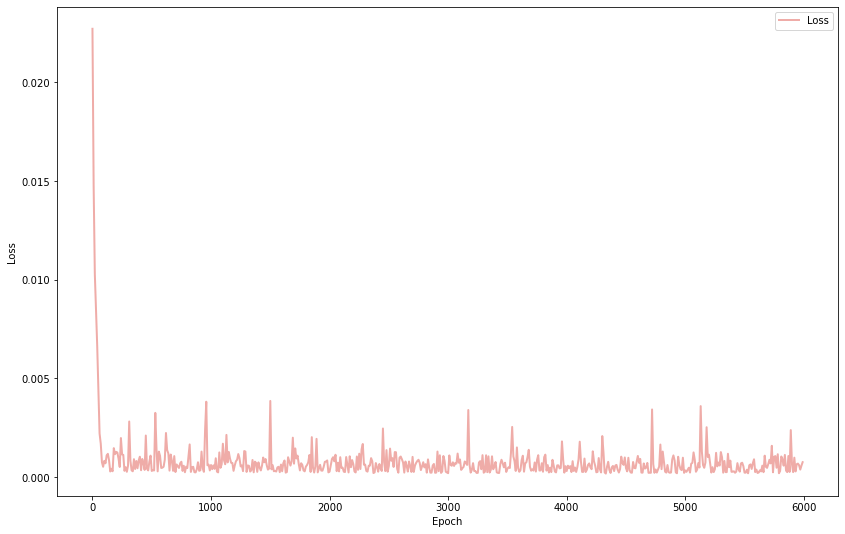

In [391]:
fig, ax = plt.subplots(
    1, 1, figsize=(14,9), 
)

# in sample loss
ax.plot(df['epoch'], df['loss'], label='Loss',linewidth=2, alpha=0.4, color='#d73027')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [398]:
# generate results from an unseen data chunk
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)

torch.Size([1, 8, 201, 18, 36])
torch.Size([1, 8, 201, 90, 180])


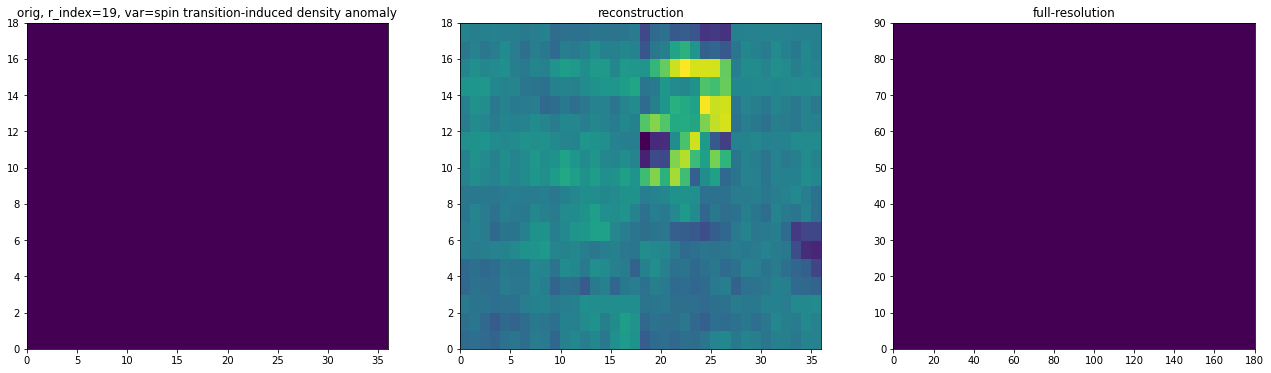

In [522]:
###############################
# concatenate along sides
pad_lat = 0

if pad_lat > 0:
    x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
    x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 0

if pad_lon > 0:
    x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
                  axis=-2) # append along longitudinal (left-right) axis

    x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                         x_large, 
                         torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                        axis=-2)

# only select 9 raidal layers, and 2 variables ("channels")
radial_index_start = 27

r_start = np.random.randint(0,201-27)
r_end = r_start+27

roll_int = np.random.randint(0,18)
        
x_roll = torch.roll(x[:,:,r_start:r_end,:,:], roll_int, 4)

x_large_roll = torch.roll(x_large[:,:,r_start:r_end,:,:], roll_int*5, 4)
x_reconstruction = test(x_roll, model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,27)
var_index = np.random.randint(0,len(var_list))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
ax[0].pcolormesh(x_roll[0,var_index,r_index,:,:].detach())
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
ax[2].set_title('full-resolution')
plt.show()

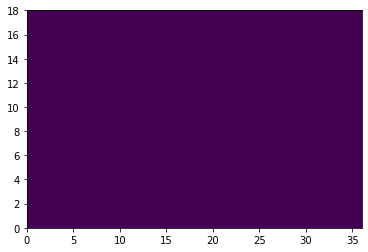

In [526]:
# some of the "spin transition-induced density anomaly values are bad"
plt.pcolormesh(x[0,7,136+19,:,:])

## Try adding a radial label channel
We will add a radial label channel, from 0 to 1, indicating what the volume is

In [533]:
x.shape

torch.Size([1, 8, 201, 18, 36])

In [559]:
a = []
for i, val in enumerate(np.arange(0,1, 1/201)):
    a.append(np.full(shape=(18,36), fill_value=val))
    
s = np.expand_dims(np.stack(a), axis=0)
s.shape

(1, 201, 18, 36)

In [554]:
x.shape

torch.Size([1, 8, 201, 18, 36])

In [588]:
# generate results from an unseen data chunk
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
a = []
for i, val in enumerate(np.arange(0,1, 1/201)):
    a.append(np.full(shape=(18,36), fill_value=val))
    
a = np.expand_dims(np.stack(a), axis=0)


x = np.expand_dims(np.concatenate((np.moveaxis(x, source=[3, 0], destination=[0,2]),s),axis=0), axis=0)
x = torch.tensor(x, dtype=torch.float32)
print(x.shape)

# x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
# print(x.shape)

torch.Size([1, 9, 201, 18, 36])


In [593]:
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
x = x[:,:,:,:,:]
print(x.shape)

x_large = torch.tensor(np.expand_dims(np.moveaxis(x_large, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x_large.shape)

torch.Size([1, 8, 201, 18, 36])
torch.Size([1, 8, 201, 90, 180])


In [600]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            nn.Conv3d(in_channels=8, out_channels=256, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(256),
            nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
#             nn.Dropout(self.drop_p),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
#             nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
            
        )
        
        self.decoder = nn.Sequential(
#             nn.Conv3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.ConvTranspose3d(in_channels=128, out_channels=256, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.ConvTranspose3d(in_channels=256, out_channels=8, kernel_size=3, stride=3, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [601]:
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1       [-1, 8, 201, 18, 36]               0
            Conv3d-2       [-1, 256, 67, 6, 12]          55,552
         LeakyReLU-3       [-1, 256, 67, 6, 12]               0
       BatchNorm3d-4       [-1, 256, 67, 6, 12]             512
            Conv3d-5        [-1, 128, 22, 2, 4]         884,864
         LeakyReLU-6        [-1, 128, 22, 2, 4]               0
       BatchNorm3d-7        [-1, 128, 22, 2, 4]             256
            Conv3d-8         [-1, 64, 22, 2, 4]           8,256
         LeakyReLU-9         [-1, 64, 22, 2, 4]               0
      BatchNorm3d-10         [-1, 64, 22, 2, 4]             128
  ConvTranspose3d-11        [-1, 128, 22, 2, 4]           8,320
        LeakyReLU-12        [-1, 128, 22, 2, 4]               0
      BatchNorm3d-13        [-1, 128, 22, 2, 4]             256
  ConvTranspose3d-14       [-1, 256, 66

In [602]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        r_start = np.random.randint(0,201-27)
        r_end = r_start+27
        
        batch_x_roll = torch.roll(x_device[:,:,r_start:r_end,:,:], np.random.randint(0,18), 4)
        recon = model(batch_x_roll)
        loss = criterion(recon, batch_x_roll)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 100 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 10 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [604]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

model = Autoencoder(drop_p=0.2)
model.to(device)
df = train(x, model, device, num_epochs=6000, learning_rate=1e-3,)
clear_output(wait=False)

Text(0, 0.5, 'Loss')

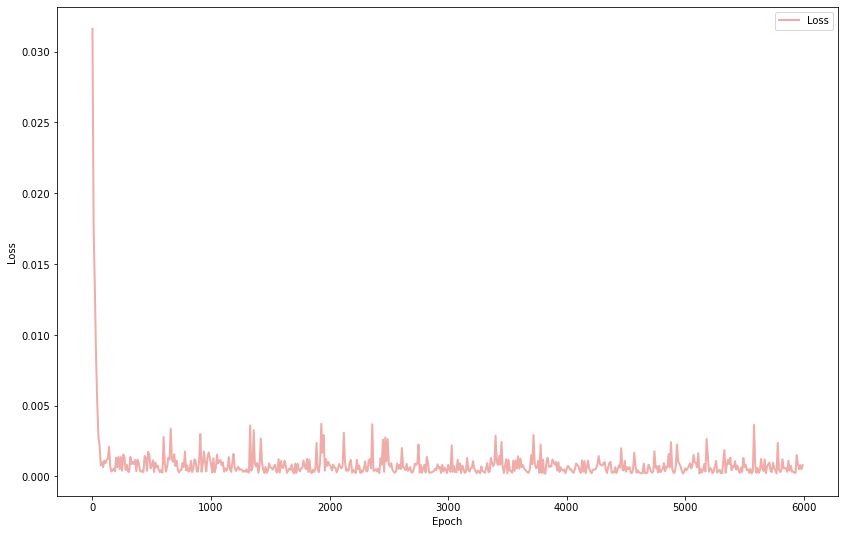

In [605]:
fig, ax = plt.subplots(
    1, 1, figsize=(14,9), 
)

# in sample loss
ax.plot(df['epoch'], df['loss'], label='Loss',linewidth=2, alpha=0.4, color='#d73027')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [585]:
# generate results from an unseen data chunk
# load back the file
with h5py.File("data_scaled_array_10percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
a = []
for i, val in enumerate(np.arange(0,1, 1/201)):
    a.append(np.full(shape=(18,36), fill_value=val))
    
a = np.expand_dims(np.stack(a), axis=0)


x = np.expand_dims(np.concatenate((np.moveaxis(x, source=[3, 0], destination=[0,2]),s),axis=0), axis=0)
x = torch.tensor(x, dtype=torch.float32)
print(x.shape)

torch.Size([1, 9, 201, 18, 36])


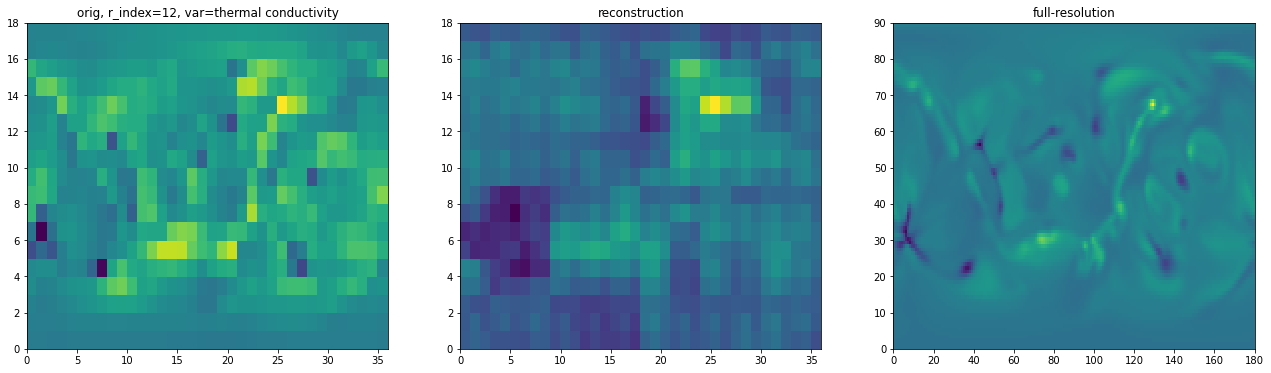

In [620]:
###############################
# concatenate along sides
pad_lat = 0

if pad_lat > 0:
    x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
    x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 0

if pad_lon > 0:
    x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
                  axis=-2) # append along longitudinal (left-right) axis

    x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                         x_large, 
                         torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                        axis=-2)

# only select 9 raidal layers, and 2 variables ("channels")
radial_index_start = 27

r_start = np.random.randint(0,201-27)
r_end = r_start+27

roll_int = np.random.randint(0,18)
        
x_roll = torch.roll(x[:,:,r_start:r_end,:,:], roll_int, 4)

x_large_roll = torch.roll(x_large[:,:,r_start:r_end,:,:], roll_int*5, 4)
x_reconstruction = test(x_roll, model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,27)
var_index = np.random.randint(0,len(var_list))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
ax[0].pcolormesh(x_roll[0,var_index,r_index,:,:].detach())
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
ax[2].set_title('full-resolution')
plt.show()

# Try Overfitting on Full-Resolution (90x180) Data
Load the data first.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to clear outputs from cells
from IPython.display import clear_output

In [2]:
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)
    

In [3]:
# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')
    
# with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
#     x_large = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)

# only select first variable
x = x[:,:1,:,:,:]
print(x.shape)

torch.Size([1, 1, 201, 90, 180])


Explore possible layer combinations.

In [13]:
conv1 = nn.Conv3d(in_channels=1, out_channels=256, kernel_size=4, stride=3, dilation=1)
conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=2, stride=1, dilation=1)
conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=2, stride=1, dilation=1)
conv4 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1)
conv5 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1)

conv6 = nn.ConvTranspose3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1)
conv7 = nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1)
conv8 = nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, dilation=1)
conv9 = nn.ConvTranspose3d(in_channels=128, out_channels=256, kernel_size=2, stride=1, dilation=1)
conv10 = nn.ConvTranspose3d(in_channels=256, out_channels=1, kernel_size=3, stride=3, dilation=1)

layer_list = [conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10]

print('input x shape:', x[:,:,:18,:,:].shape)

for i, l in enumerate(layer_list):
    if i == 0:
        output = l(x[:,:,:18,:,:])
        print(f'conv{i+1} output:', output.shape)
    else:
        output = l(output)
        print(f'conv{i+1} output:', output.shape)

input x shape: torch.Size([1, 1, 18, 90, 180])
conv1 output: torch.Size([1, 256, 6, 30, 60])
conv2 output: torch.Size([1, 128, 5, 29, 59])
conv3 output: torch.Size([1, 64, 4, 28, 58])
conv4 output: torch.Size([1, 32, 4, 28, 58])
conv5 output: torch.Size([1, 32, 4, 28, 58])
conv6 output: torch.Size([1, 32, 4, 28, 58])
conv7 output: torch.Size([1, 64, 4, 28, 58])
conv8 output: torch.Size([1, 128, 5, 29, 59])
conv9 output: torch.Size([1, 256, 6, 30, 60])
conv10 output: torch.Size([1, 1, 18, 90, 180])


In [21]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=4, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
#             nn.Conv3d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(32),
#             nn.Conv3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(32),
            
        )
        
        self.decoder = nn.Sequential(
#             nn.ConvTranspose3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(32),
#             nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=1, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.ConvTranspose3d(in_channels=128, out_channels=1, kernel_size=4, stride=1, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU


In [16]:
# use pytorch-summary https://github.com/sksq96/pytorch-summary
# with torch.no_grad():
#     torch.cuda.empty_cache()

from torchsummary import summary
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 7.93 GiB total capacity; 6.79 GiB already allocated; 10.44 MiB free; 6.81 GiB reserved in total by PyTorch)

In [11]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        r_start = np.random.randint(0,201-18)
        r_end = r_start+18
        
#         batch_x_roll = torch.roll(x_device[:,:,r_start:r_end,:,:], np.random.randint(0,90), 4)
        batch_x_roll = x_device[:,:,0:18,:,:]
        recon = model(batch_x_roll)
        loss = criterion(recon, batch_x_roll)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 50 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 2 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [23]:
model = Autoencoder(drop_p=0.2)
model.to(device)
df = train(x, model, device, num_epochs=200, learning_rate=1e-3,)
clear_output(wait=False)

In [29]:
###############################
# concatenate along sides
pad_lat = 0

if pad_lat > 0:
    x = torch.cat((x[:,:,:,:,-pad_lat:], x, x[:,:,:,:,:pad_lat]), axis=-1)
    x_large = torch.cat((x_large[:,:,:,:,-pad_lat:], x_large, x_large[:,:,:,:,:pad_lat]), axis=-1)

# mirror top and bottom rows
# we don't want to double the top/bottom row, so we only select n-1 row
pad_lon = 0

if pad_lon > 0:
    x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_lon-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_lon+1,:]), # mirror array and select bottom rows
                  axis=-2) # append along longitudinal (left-right) axis

    x_large = torch.cat((torch.flip(x_large, [3])[:,:,:,-pad_lon-1:-1,:], 
                         x_large, 
                         torch.flip(x_large, [3])[:,:,:,1:pad_lon+1,:]), 
                        axis=-2)

# only select 9 raidal layers, and 2 variables ("channels")
radial_index_start = 30

r_start = np.random.randint(0,201-30)
r_end = r_start+30

roll_int = np.random.randint(0,18)
        
# x_roll = torch.roll(x[:,:,r_start:r_end,:,:], roll_int, 4)
# x_roll = torch.roll(x[:,:,0:18,:,:], 0, 4)

# x_large_roll = torch.roll(x_large[:,:,r_start:r_end,:,:], roll_int*5, 4)
x_reconstruction = test(x[:,:,:18,:,:], model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,18)
# var_index = np.random.randint(0,len(var_list))
var_index = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
# ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
# ax[2].set_title('full-resolution')
plt.show()

RuntimeError: CUDA error: unspecified launch failure

Text(0, 0.5, 'Loss')

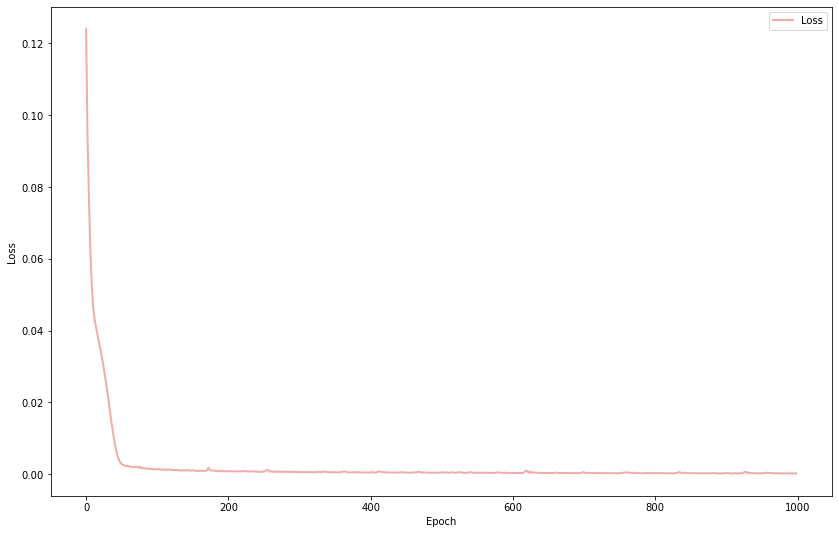

In [231]:
fig, ax = plt.subplots(
    1, 1, figsize=(14,9), 
)

# in sample loss
ax.plot(df['epoch'], df['loss'], label='Loss',linewidth=2, alpha=0.4, color='#d73027')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Train on a 30x30x30 Volume

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to clear outputs from cells
from IPython.display import clear_output

In [141]:
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)

# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

radial_i_start = 3
lat_start = 30
lon_start = 30

# only select first variable
x = x[:,:1,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]
print(x.shape)

torch.Size([1, 8, 201, 90, 180])
torch.Size([1, 1, 30, 30, 30])


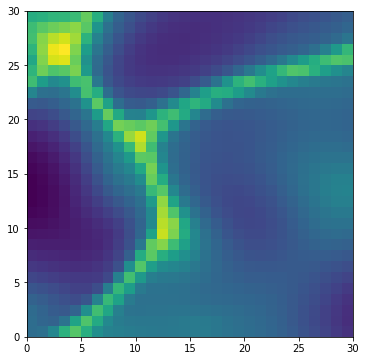

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22,6))
ax.pcolormesh(x[0,0,0,:,:])
ax.set_aspect(aspect='equal')
plt.show()

In [65]:
conv1 = nn.Conv3d(in_channels=1, out_channels=256, kernel_size=2, stride=1, dilation=1)
conv2 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=2, stride=1, dilation=1)
conv3 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=2, stride=1, dilation=1)
conv4 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=2, stride=1, dilation=1)
conv5 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1)

conv6 = nn.ConvTranspose3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1)
conv7 = nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=2, stride=1, dilation=1)
conv8 = nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, dilation=1)
conv9 = nn.ConvTranspose3d(in_channels=128, out_channels=256, kernel_size=2, stride=1, dilation=1)
conv10 = nn.ConvTranspose3d(in_channels=256, out_channels=1, kernel_size=2, stride=1, dilation=1)

layer_list = [conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10]

print('input x shape:', x.shape)

for i, l in enumerate(layer_list):
    if i == 0:
        output = l(x)
        print(f'conv{i+1} output:', output.shape)
    else:
        output = l(output)
        print(f'conv{i+1} output:', output.shape)

input x shape: torch.Size([1, 1, 30, 30, 30])
conv1 output: torch.Size([1, 256, 29, 29, 29])
conv2 output: torch.Size([1, 128, 28, 28, 28])
conv3 output: torch.Size([1, 64, 27, 27, 27])
conv4 output: torch.Size([1, 32, 26, 26, 26])
conv5 output: torch.Size([1, 32, 26, 26, 26])
conv6 output: torch.Size([1, 32, 26, 26, 26])
conv7 output: torch.Size([1, 64, 27, 27, 27])
conv8 output: torch.Size([1, 128, 28, 28, 28])
conv9 output: torch.Size([1, 256, 29, 29, 29])
conv10 output: torch.Size([1, 1, 30, 30, 30])


In [102]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            nn.Conv3d(in_channels=1, out_channels=256, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.Conv3d(in_channels=256, out_channels=128, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=32, out_channels=32, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32),
            nn.ConvTranspose3d(in_channels=32, out_channels=64, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(64),
            nn.ConvTranspose3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            nn.ConvTranspose3d(in_channels=128, out_channels=256, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(256),
            nn.ConvTranspose3d(in_channels=256, out_channels=1, kernel_size=1, stride=1, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [103]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        recon = model(x_device)
        loss = criterion(recon, x_device)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 50 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 2 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [104]:
from torchsummary import summary
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1        [-1, 1, 30, 30, 30]               0
            Conv3d-2      [-1, 256, 30, 30, 30]             512
         LeakyReLU-3      [-1, 256, 30, 30, 30]               0
       BatchNorm3d-4      [-1, 256, 30, 30, 30]             512
            Conv3d-5      [-1, 128, 29, 29, 29]         262,272
         LeakyReLU-6      [-1, 128, 29, 29, 29]               0
       BatchNorm3d-7      [-1, 128, 29, 29, 29]             256
            Conv3d-8       [-1, 64, 28, 28, 28]          65,600
         LeakyReLU-9       [-1, 64, 28, 28, 28]               0
      BatchNorm3d-10       [-1, 64, 28, 28, 28]             128
           Conv3d-11       [-1, 32, 27, 27, 27]          16,416
        LeakyReLU-12       [-1, 32, 27, 27, 27]               0
      BatchNorm3d-13       [-1, 32, 27, 27, 27]              64
           Conv3d-14       [-1, 32, 27,

In [121]:
model = Autoencoder(drop_p=0.2)
model.to(device)
df = train(x, model, device, num_epochs=800, learning_rate=1e-3,)
clear_output(wait=False)

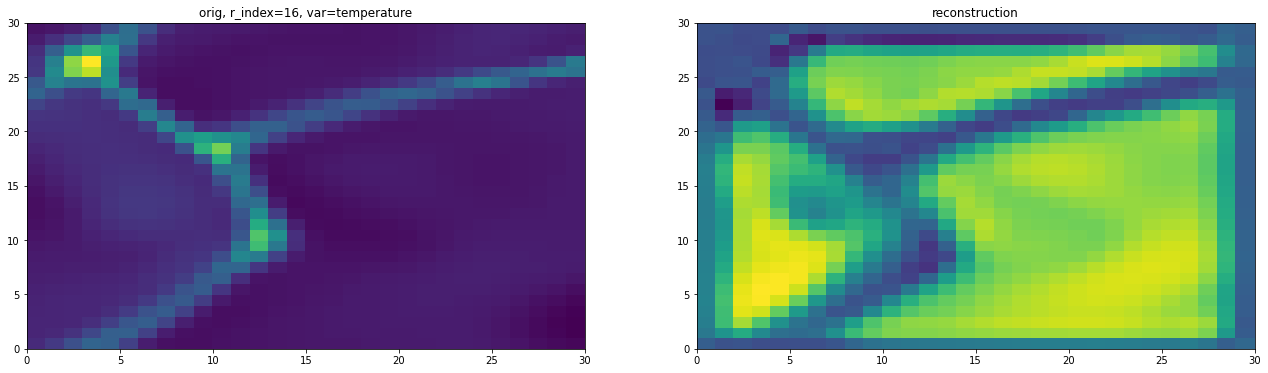

In [130]:

x_reconstruction = test(x, model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,30)
# var_index = np.random.randint(0,len(var_list))
var_index = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
# ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
# ax[2].set_title('full-resolution')
plt.show()

# Simple Autoencoder Practice
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to clear outputs from cells
from IPython.display import clear_output

In [2]:
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)

# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

radial_i_start = 3
lat_start = 30
lon_start = 30

# only select first variable
x = x[:,:1,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]
print(x.shape)

torch.Size([1, 8, 201, 90, 180])
torch.Size([1, 1, 30, 30, 30])


In [10]:
conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=2, stride=1, dilation=1)

flat1 = nn.Flatten()

dense1 = nn.Linear(128, 128)




conv2 = nn.ConvTranspose3d(in_channels=16, out_channels=1, kernel_size=2, stride=1, dilation=1)

layer_list = [conv1, flat1,'reshape1', conv2, ]

print('input x shape:', x.shape)

for i, l in enumerate(layer_list):
    if i == 0:
        output = l(x)
        print(f'{str(l):<90}{str(output.shape):>30}')
    elif l == 'reshape1':
        output = output.view((1,-1,29,29,29))
        print(f'{str(l):<90}{str(output.shape):>30}')
    else:
        output = l(output)
        print(f'{str(l):<90}{str(output.shape):>30}')

input x shape: torch.Size([1, 1, 30, 30, 30])
Conv3d(1, 16, kernel_size=(2, 2, 2), stride=(1, 1, 1))                                    torch.Size([1, 16, 29, 29, 29])
Flatten(start_dim=1, end_dim=-1)                                                                 torch.Size([1, 390224])
reshape1                                                                                  torch.Size([1, 16, 29, 29, 29])
ConvTranspose3d(16, 1, kernel_size=(2, 2, 2), stride=(1, 1, 1))                           torch.Size([1, 1, 30, 30, 30])


In [40]:
class Autoencoder(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Autoencoder, self).__init__()
        self.drop_p = drop_p
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Dropout(self.drop_p),
            
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(16),
            nn.Flatten()
            
        )
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=16, out_channels=1, kernel_size=2, stride=1, dilation=1),         

            nn.Sigmoid()
        )

    def forward(self, x):
#         print('input x.shape:', x.shape)
        x = self.encoder(x)
#         print('x.shape:', x.shape)
        x = x.view(x.shape[0],-1,29,29,29)
#         print('x.shape:', x.shape)
        x = self.decoder(x)
        return x

In [41]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        recon = model(x_device)
        loss = criterion(recon, x_device)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 50 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 2 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [42]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU


In [43]:
from torchsummary import summary
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1        [-1, 1, 30, 30, 30]               0
            Conv3d-2       [-1, 16, 29, 29, 29]             144
         LeakyReLU-3       [-1, 16, 29, 29, 29]               0
       BatchNorm3d-4       [-1, 16, 29, 29, 29]              32
           Flatten-5               [-1, 390224]               0
   ConvTranspose3d-6        [-1, 1, 30, 30, 30]             129
           Sigmoid-7        [-1, 1, 30, 30, 30]               0
Total params: 305
Trainable params: 305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 12.53
Params size (MB): 0.00
Estimated Total Size (MB): 12.63
----------------------------------------------------------------


In [44]:
model = Autoencoder(drop_p=0.2)
model.to(device)
df = train(x, model, device, num_epochs=500, learning_rate=1e-3,)
clear_output(wait=False)

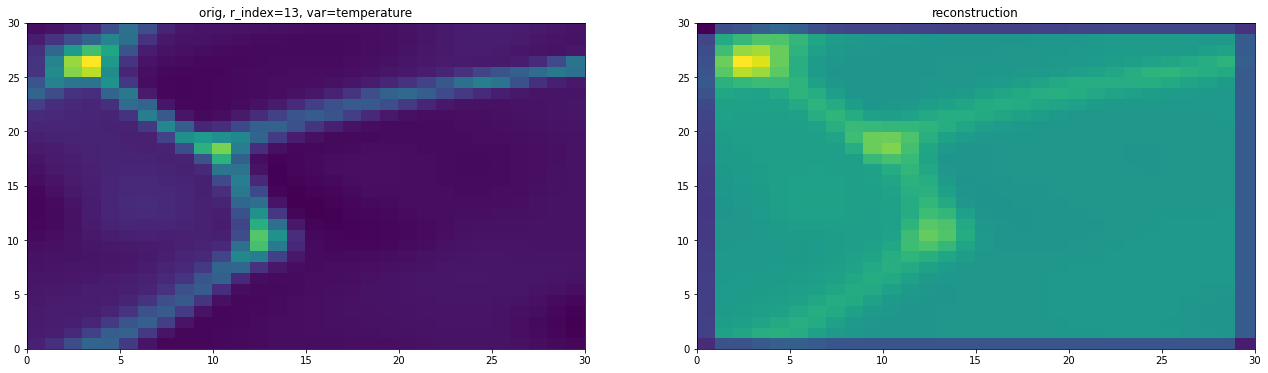

In [45]:

x_reconstruction = test(x, model, device)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,30)
# var_index = np.random.randint(0,len(var_list))
var_index = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
ax[0].pcolormesh(x[0,var_index,r_index,:,:])
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
# ax[2].pcolormesh(x_large_roll[0,var_index,r_index,:,:])
# ax[2].set_title('full-resolution')
plt.show()

# Try Upsample/Conv instead of Conv Transpose

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to clear outputs from cells
from IPython.display import clear_output

In [361]:
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)

# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

radial_i_start = 1
lat_start = 30
lon_start = 30

# only select first variable
x = x[:,:2,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]
print(x.shape)

torch.Size([1, 8, 201, 90, 180])
torch.Size([1, 2, 30, 30, 30])


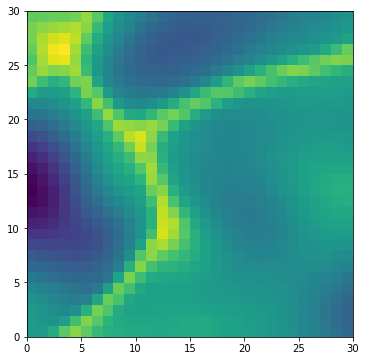

In [225]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22,6))
ax.pcolormesh(x[0,0,0,:,:])
ax.set_aspect(aspect='equal')
plt.show()

Implement autoencoder: https://visualstudiomagazine.com/articles/2021/04/13/autoencoder-anomaly-detection.aspx

In [226]:
conv1 = nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=3, dilation=1)
max1 = nn.MaxPool3d((2, 2, 2))
conv2 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=2, stride=1, dilation=1)
conv3 = nn.Conv3d(in_channels=64, out_channels=32, kernel_size=2, stride=1, dilation=1)
conv4 = nn.Conv3d(in_channels=32, out_channels=16, kernel_size=2, stride=1, dilation=1)
flat1 = nn.Flatten()

dense1 = nn.Linear(864, 864)

# conv4 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=2, stride=1, dilation=1, padding=(1,1,1), padding_mode='replicate')
# up1 = nn.Upsample(scale_factor=(2,2,2))
conv5 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=2, stride=1, dilation=1)
up2 = nn.Upsample(scale_factor=(2,2,2))
# conv5 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, dilation=1, padding=(2,2,2), padding_mode='replicate')
conv6 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, dilation=1)
up3 = nn.Upsample(scale_factor=(2,2,2))
conv7 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, dilation=1)
up4 = nn.Upsample(scale_factor=(2,2,2))
conv8 = nn.Conv3d(in_channels=128, out_channels=1, kernel_size=2, stride=1, dilation=1)
conv9 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=2, stride=1, dilation=1)
conv10 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=2, stride=1, dilation=1)
conv11 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=1, stride=1, dilation=1)

# layer_list = [conv1, conv2, conv3, conv4, conv5, conv6]
layer_list = [conv1, max1, conv2, conv3, flat1, dense1, 'reshape1', 
              conv6, up3, conv7, up4, conv8, up4, conv9, conv10, conv11]

print('input x shape:', x.shape)

for i, l in enumerate(layer_list):
    if i == 0:
        output = l(x)
        print(f'{str(l):<90}{str(output.shape):>30}')
    elif l == 'reshape1':
        output = output.view((1,-1,3,3,3))
        print(f'{str(l):<90}{str(output.shape):>30}')
    else:
        output = l(output)
        print(f'{str(l):<90}{str(output.shape):>30}')

input x shape: torch.Size([1, 1, 30, 30, 30])
Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(3, 3, 3))                                   torch.Size([1, 128, 10, 10, 10])
MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False) torch.Size([1, 128, 5, 5, 5])
Conv3d(128, 64, kernel_size=(2, 2, 2), stride=(1, 1, 1))                                    torch.Size([1, 64, 4, 4, 4])
Conv3d(64, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))                                     torch.Size([1, 32, 3, 3, 3])
Flatten(start_dim=1, end_dim=-1)                                                                    torch.Size([1, 864])
Linear(in_features=864, out_features=864, bias=True)                                                torch.Size([1, 864])
reshape1                                                                                    torch.Size([1, 32, 3, 3, 3])
Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))                                     torch.Size([1

RuntimeError: Calculated padded input size per channel: (1 x 1 x 1). Kernel size: (2 x 2 x 2). Kernel size can't be greater than actual input size

In [440]:
class Autoencoder(nn.Module):
    def __init__(self, prob_drop=0.2):
        super(Autoencoder, self).__init__()
        self.prob_drop = prob_drop
        
        self.encoder = nn.Sequential(
            nn.Dropout(self.prob_drop),
             
            nn.Conv3d(in_channels=2, out_channels=128, kernel_size=3, stride=3, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128), 
            nn.MaxPool3d((2, 2, 2)),
             
            nn.Conv3d(in_channels=128, out_channels=64, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32), 
            
            nn.Conv3d(in_channels=32, out_channels=16, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            
         )
        
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=(2,2,2)),
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(32), 
            
            nn.Upsample(scale_factor=(2,2,2)),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=(3,3,3)),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=(3,3,3)),
            nn.BatchNorm3d(128),
            
            nn.Conv3d(in_channels=128, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels=128, out_channels=128, kernel_size=1, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(128),
            
            nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels=128, out_channels=2, kernel_size=2, stride=1, dilation=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(2),
            
#             nn.Conv3d(in_channels=128, out_channels=2, kernel_size=2, stride=1, dilation=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(2),
            nn.Conv3d(in_channels=2, out_channels=2, kernel_size=1, stride=1, dilation=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
#         print('input x.shape:', x.shape)
        x = self.encoder(x)
#         print('x.shape:', x.shape)
        x = x.view(x.shape[0],-1,2,2,2)
#         print('x.shape:', x.shape)
        x = self.decoder(x)
        return x

In [441]:
# setup to run on GPU (or CPU if GPU not avail.)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU


In [442]:
tuple(list(x.shape)[1:])

(2, 30, 30, 30)

In [443]:
# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

radial_i_start = 1
lat_start = 30
lon_start = 30

# only select first variable
x = x[:,:2,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]

from torchsummary import summary
model = Autoencoder()
model.to(device)
summary(model, tuple(list(x.shape)[1:]))

torch.Size([1, 8, 201, 90, 180])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1        [-1, 2, 30, 30, 30]               0
            Conv3d-2      [-1, 128, 10, 10, 10]           7,040
         LeakyReLU-3      [-1, 128, 10, 10, 10]               0
       BatchNorm3d-4      [-1, 128, 10, 10, 10]             256
         MaxPool3d-5         [-1, 128, 5, 5, 5]               0
            Conv3d-6          [-1, 64, 4, 4, 4]          65,600
         LeakyReLU-7          [-1, 64, 4, 4, 4]               0
            Conv3d-8          [-1, 32, 3, 3, 3]          16,416
         LeakyReLU-9          [-1, 32, 3, 3, 3]               0
      BatchNorm3d-10          [-1, 32, 3, 3, 3]              64
           Conv3d-11          [-1, 16, 2, 2, 2]           4,112
        LeakyReLU-12          [-1, 16, 2, 2, 2]               0
          Flatten-13                  [-1, 128]               0
      

In [444]:
def train(x, model, device, num_epochs=5, learning_rate=1e-3,):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    df = pd.DataFrame()
    x_device = x.to(device)
    for epoch in range(num_epochs):
        
        radial_i_start = np.random.randint(1,201-30)
        
        lat_start = np.random.randint(0,90-30)
        lon_start = np.random.randint(0,180-30)
        var_start = np.random.randint(1,2)
#         print(var_start)

        # only select first variable
        x_roll = x_device[:,0:2,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]
        
        
        recon = model(x_roll)
        loss = criterion(recon, x_roll)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch % 200 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        if epoch % 2 == 0:
            df = df.append(pd.DataFrame([[epoch, loss.item(),]],
                                            columns=['epoch', 'loss',]))
    
    return df
    
def test(x, model, device):
    model.eval()
    with torch.no_grad():  

        batch_x = x.to(device)
        outputs = model(batch_x)

    return outputs.cpu()

In [445]:
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)

# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    x = f["data_scaled_array"][:].astype('float16')

# move variables (either temperature, velocity, etc) to from (these are channels)
# move height (latitudes) before width (longitudes)
x = torch.tensor(np.expand_dims(np.moveaxis(x, source=[3, 0], destination=[0,2]),0), dtype=torch.float32)
print(x.shape)

model = Autoencoder(prob_drop=0.1)
model.to(device)
df = train(x, model, device, num_epochs=2000, learning_rate=1e-3,)
clear_output(wait=False)

torch.Size([1, 2, 30, 30, 30])


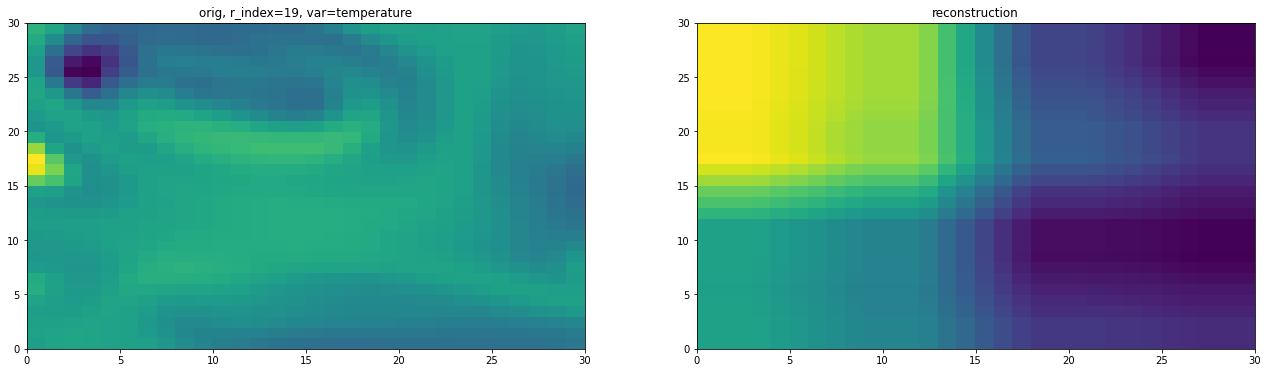

In [481]:
radial_i_start = np.random.randint(1,201-30)
lat_start = np.random.randint(0,90-30)
lon_start = np.random.randint(0,180-30)

# only select first variable
x_test = x[:,:2,radial_i_start:radial_i_start+30, lat_start:lat_start+30, lon_start:lon_start+30]


x_reconstruction = test(x_test, model, device)
print(x_reconstruction.shape)

# var list ['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 
#          'temperature anomaly', 'spin transition-induced density anomaly']


r_index = np.random.randint(0,30)
var_index = 0

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
ax[0].pcolormesh(x_test[0,var_index,r_index,:,:])
ax[0].set_title(f'orig, r_index={r_index}, var={var_list[var_index]}')
ax[1].pcolormesh(x_reconstruction[0,var_index,r_index,:,:].detach())
ax[1].set_title('reconstruction')
plt.show()

In [284]:
df.head()

,epoch,loss
0,0,0.030829
0,2,0.030497
0,4,0.019910
0,6,0.024487
0,8,0.022334


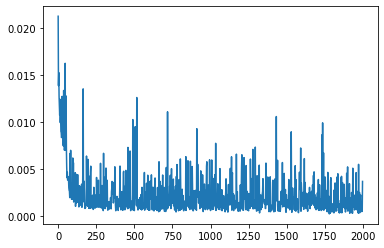

In [359]:
plt.plot(df['epoch'],df['loss'])